In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman as nemenyi
from quality.create_quality_df import create_pred_df, calculate_measures

In [3]:
df = pd.read_pickle("/home/dobraczka/Downloads/git/er-embedding-benchmark/data/all_quality_measures.pkl")
df["model_name"] = df["model_name"].map({"ada boost":"ada","decision tree":"dt","gaussian naive bayes":"bayes","random forest 500":"rf","svc":"svc","MLP":"MLP","logistic regression":"lr"})
df = df[df["model_name"].isin(["ada","dt","bayes","rf","MLP"])]
rich_graph_datasets = {"D_W_15K_V1", "D_W_15K_V2", "D_Y_15K_V1", "D_Y_15K_V2", "EN_DE_15K_V1", "EN_DE_15K_V2", "EN_FR_15K_V1", "EN_FR_15K_V2"}
rich_graph_datasets ={
        "D_W_15K_V1",
    "D_W_15K_V2",
    "D_Y_15K_V1",
    "D_Y_15K_V2",
    "EN_DE_15K_V1",
    "EN_DE_15K_V2",
    "EN_FR_15K_V1",
    "EN_FR_15K_V2",
    "D_W_100K_V1",
    "D_W_100K_V2",
    "D_Y_100K_V1",
    "D_Y_100K_V2",
    "EN_DE_100K_V1",
    "EN_DE_100K_V2",
    "EN_FR_100K_V1",
    "EN_FR_100K_V2",
}
rich_df = df[df["dataset"].isin(rich_graph_datasets)]
shallow_df = df[~df["dataset"].isin(rich_graph_datasets)]

In [4]:
def create_piv(df, embed_model):
    df_shortened = df[df["embed_model"]==embed_model].drop("embed_model",axis=1)
    df_shortened["model_name"] = df_shortened["model_name"].map({"ada boost":"ada","decision tree":"dt","gaussian naive bayes":"bayes","random forest 500":"rf","svc":"svc","MLP":"MLP","logistic regression":"lr"})
    return df_shortened.pivot_table(index=["embed_model","dataset"],columns=["vector_name","model_name"],values="fm")

In [43]:
def create_piv_big(df):
    df_shortened = df.copy()
    df_shortened["model_name"] = df_shortened["model_name"].map({"ada boost":"ada","decision tree":"dt","gaussian naive bayes":"bayes","random forest 500":"rf","svc":"svc","MLP":"MLP","logistic regression":"lr"})
    df_shortened["dataset"] = df_shortened["dataset"].map({"D_W_15K_V1":"01D-W 15K (V1)","D_W_15K_V2":"02D-W 15K (V2)","D_Y_15K_V1":"03D-Y 15K (V1)","D_Y_15K_V2":"04D-Y 15K (V2)","EN_DE_15K_V1":"05EN-DE 15K (V1)","EN_DE_15K_V2":"06EN-DE 15K (V2)","EN_FR_15K_V1":"07EN-FR 15K (V1)","EN_FR_15K_V2":"08EN-FR 15K (V2)","D_W_100K_V1":"09D-W 100K (V1)","D_W_100K_V2":"10D-W 100K (V2)","D_Y_100K_V1":"11D-Y 100K (V1)","D_Y_100K_V2":"12D-Y 100K (V2)","EN_DE_100K_V1":"13EN-DE 100K (V1)","EN_DE_100K_V2":"14EN-DE 100K (V2)","EN_FR_100K_V1":"15EN-FR 100K (V1)","EN_FR_100K_V2":"16EN-FR 100K (V2)"})
    return df_shortened.pivot_table(index=["embed_model","dataset"],columns=["vector_name","model_name"],values="fm")

In [28]:
import math
def get_sorted_rank_groups(result, reverse):
    if reverse:
        names = result.rankdf.iloc[::-1].index.to_list()
        if result.cd is not None:
            sorted_ranks = result.rankdf.iloc[::-1].meanrank
            critical_difference = result.cd
        else:
            sorted_ranks = result.rankdf.iloc[::-1]['mean']
            critical_difference = (result.rankdf.ci_upper[0] - result.rankdf.ci_lower[0]) / 2
    else:
        names = result.rankdf.index.to_list()
        if result.cd is not None:
            sorted_ranks = result.rankdf.meanrank
            critical_difference = result.cd
        else:
            sorted_ranks = result.rankdf['mean']
            critical_difference = (result.rankdf.ci_upper[0] - result.rankdf.ci_lower[0]) / 2

    groups = []
    cur_max_j = -1
    for i in range(len(sorted_ranks)):
        max_j = None
        for j in range(i + 1, len(sorted_ranks)):
            if abs(sorted_ranks[i] - sorted_ranks[j]) <= critical_difference:
                max_j = j
                # print(i, j)
        if max_j is not None and max_j > cur_max_j:
            cur_max_j = max_j
            groups.append((i, max_j))
    return sorted_ranks, names, groups

def cd_diagram(result, reverse, ax, width):
    """
    Creates a Critical Distance diagram.
    """

    def plot_line(line, color='k', **kwargs):
        ax.plot([pos[0] / width for pos in line], [pos[1] / height for pos in line], color=color, **kwargs)

    def plot_text(x, y, s, *args, **kwargs):
        ax.text(x / width, y / height, s, *args, **kwargs)

    sorted_ranks, names, groups = get_sorted_rank_groups(result, reverse)
    cd = result.cd

    lowv = min(1, int(math.floor(min(sorted_ranks))))
    highv = max(len(sorted_ranks), int(math.ceil(max(sorted_ranks))))
    cline = 0.4
    textspace = 1
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            relative_rank = rank - lowv
        else:
            relative_rank = highv - rank
        return textspace + scalewidth / (highv - lowv) * relative_rank

    linesblank = 0.2 + 0.2 + (len(groups) - 1) * 0.1

    # add scale
    distanceh = 0.25
    cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((len(sorted_ranks) + 1) / 2) * 0.2 + minnotsignificant

    if ax is None:
        fig = plt.figure(figsize=(width, height))
        fig.set_facecolor('white')
        ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    plot_line([(textspace, cline), (width - textspace, cline)],linewidth=0.7)

    bigtick = 0.1
    smalltick = 0.05

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        plot_line([(rankpos(a), cline - tick / 2),
                   (rankpos(a), cline)],
                  linewidth=0.7)

    for a in range(lowv, highv + 1):
        plot_text(rankpos(a), cline - tick / 2 - 0.05, str(a),
                  ha="center", va="bottom")

    for i in range(math.ceil(len(sorted_ranks) / 2)):
        chei = cline + minnotsignificant + i * 0.2
        plot_line([(rankpos(sorted_ranks[i]), cline),
                   (rankpos(sorted_ranks[i]), chei),
                   (textspace - 0.1, chei)],
                  #color=colors[names[i][1]],
                  linewidth=0.7)
        plot_text(textspace - 0.2, chei, ", ".join(names[i]), ha="right", va="center")

    for i in range(math.ceil(len(sorted_ranks) / 2), len(sorted_ranks)):
        chei = cline + minnotsignificant + (len(sorted_ranks) - i - 1) * 0.2
        plot_line([(rankpos(sorted_ranks[i]), cline),
                   (rankpos(sorted_ranks[i]), chei),
                   (textspace + scalewidth + 0.1, chei)], 
                  #color=colors[names[i][1]],
                  linewidth=0.7)
        plot_text(textspace + scalewidth + 0.2, chei, ", ".join(names[i]),
                  ha="left", va="center")

    # upper scale
    if not reverse:
        begin, end = rankpos(lowv), rankpos(lowv + cd)
    else:
        begin, end = rankpos(highv), rankpos(highv - cd)

    plot_line([(begin, distanceh), (end, distanceh)], linewidth=0.7)
    plot_line([(begin, distanceh + bigtick / 2),
               (begin, distanceh - bigtick / 2)],
              linewidth=0.7)
    plot_line([(end, distanceh + bigtick / 2),
               (end, distanceh - bigtick / 2)],
              linewidth=0.7)
    plot_text((begin + end) / 2, distanceh - 0.05, "CD",
              ha="center", va="bottom")

    # no-significance lines
    side = -0.001
    no_sig_height = 0.1
    start = cline + 0.2
    for l, r in groups:
        plot_line([(rankpos(sorted_ranks[l]) - side, start),
                   (rankpos(sorted_ranks[r]) + side, start)],
                  linewidth=2.5)
        start += no_sig_height

    return ax

In [7]:
rich_df[rich_df["dataset"].str.contains("100K")]

,dataset,embed_model,vector_name,model_name,prec,rec,fm
0,D_W_100K_V1,BootEA,OnlyEmb,MLP,0.999770,0.760111,0.863591
1,D_W_100K_V1,BootEA,OnlyEmb,ada,0.500906,0.515034,0.507806
2,D_W_100K_V1,BootEA,OnlyEmb,dt,0.835755,0.535051,0.652362
3,D_W_100K_V1,BootEA,OnlyEmb,bayes,0.500328,0.531391,0.515381
4,D_W_100K_V1,BootEA,OnlyEmb,rf,0.999873,0.695874,0.820588
...,...,...,...,...,...,...,...
115,EN_FR_100K_V2,RDGCN,SimAndEmb,MLP,0.979443,0.814191,0.889058
116,EN_FR_100K_V2,RDGCN,SimAndEmb,ada,0.998413,0.759574,0.860926
117,EN_FR_100K_V2,RDGCN,SimAndEmb,dt,0.992012,0.737374,0.844643
118,EN_FR_100K_V2,RDGCN,SimAndEmb,bayes,0.971624,0.728077,0.832390


RankResult(rankdf=
                         meanrank median        mad ci_lower ci_upper  \
vector_name model_name                                                  
OnlySim     rf           2.785714  0.994  0.0029652    0.977    0.997   
SimAndEmb   rf           2.976190  0.995  0.0014826     0.97    0.997   
OnlySim     ada          4.404762  0.993  0.0044478    0.971    0.997   
SimAndEmb   ada          4.476190  0.993  0.0044478    0.968    0.997   
OnlySim     MLP          4.500000  0.982  0.0207564    0.878    0.997   
SimAndEmb   MLP          6.023810  0.993  0.0029652    0.956    0.997   
OnlySim     dt           6.476190   0.99   0.007413    0.965    0.996   
            bayes        6.642857  0.978   0.022239    0.889    0.997   
SimAndEmb   dt           8.119048  0.986  0.0133434    0.942    0.996   
            bayes        8.976190   0.92  0.0800604    0.822    0.997   
OnlyEmb     rf          11.380952  0.655   0.200151    0.504    0.916   
            MLP         11.95238

/home/dobraczka/.local/share/virtualenvs/er-embedding-benchmark-_gu3Nn8a/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  
/home/dobraczka/.local/share/virtualenvs/er-embedding-benchmark-_gu3Nn8a/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


<Figure size 432x288 with 0 Axes>

/home/dobraczka/.local/share/virtualenvs/er-embedding-benchmark-_gu3Nn8a/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


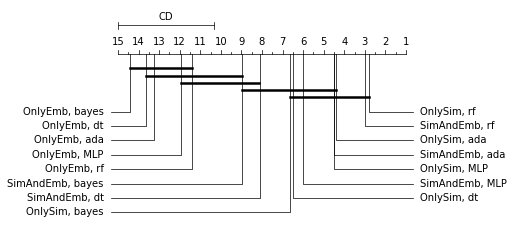

In [33]:
from autorank import autorank, plot_stats, create_report, latex_table
wanted = shallow_df.pivot_table(index=["embed_model","dataset"],columns=["vector_name","model_name"],values="fm").round(3)
#wanted.columns = [c for c in wanted.columns]
result = autorank(wanted, alpha=0.05, verbose=False)
print(result)
plt.tight_layout()
ax = cd_diagram(result,True,None,width=6)
plt.savefig("/tmp/shallow_cd.pdf",bbox_inches="tight")
ax

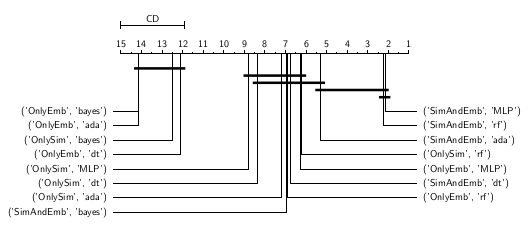

In [40]:
wanted = rich_df.pivot_table(index=["embed_model","dataset"],columns=["vector_name","model_name"],values="fm").round(3)
#wanted.columns = [c for c in wanted.columns]
result = autorank(wanted, alpha=0.05, verbose=False)
ax = plot_stats(result,width=6)
plt.savefig('/tmp/rich_cd.pgf')
ax

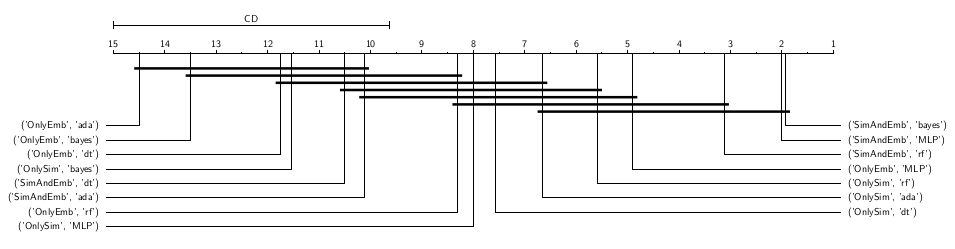

In [32]:
wanted = rich_df[rich_df["embed_model"].str.contains("BootEA")].pivot_table(index=["embed_model","dataset"],columns=["vector_name","model_name"],values="fm").round(3)
#wanted.columns = [c for c in wanted.columns]
result = autorank(wanted, alpha=0.05, verbose=False)
ax = plot_stats(result,width=12)
ax

In [58]:
df = rich_df[["model_name","vector_name","fm","dataset","embed_model"]]
piv_b = create_piv(df, "BootEA")
piv_m = create_piv(df, "MultiKE")
piv_r = create_piv(df, "RDGCN")

In [45]:
import sys
sys.path.append("/home/dobraczka/Downloads/git/CSVtoLaTeXTable/colorizelatextables")
from colorize_table import to_colorized_latex, add_avg_rank

In [46]:
r = add_avg_rank(big)
r.apply(lambda x : "Avg Rank" in x.name, axis=1)

embed_model  dataset          
BootEA       01D-W 15K (V1)       False
             02D-W 15K (V2)       False
             03D-Y 15K (V1)       False
             04D-Y 15K (V2)       False
             05EN-DE 15K (V1)     False
             06EN-DE 15K (V2)     False
             07EN-FR 15K (V1)     False
             08EN-FR 15K (V2)     False
             09D-W 100K (V1)      False
             10D-W 100K (V2)      False
             11D-Y 100K (V1)      False
             12D-Y 100K (V2)      False
             13EN-DE 100K (V1)    False
             14EN-DE 100K (V2)    False
             15EN-FR 100K (V1)    False
             16EN-FR 100K (V2)    False
MultiKE      01D-W 15K (V1)       False
             02D-W 15K (V2)       False
             03D-Y 15K (V1)       False
             04D-Y 15K (V2)       False
             05EN-DE 15K (V1)     False
             06EN-DE 15K (V2)     False
             07EN-FR 15K (V1)     False
             08EN-FR 15K (V2)     False
         

In [47]:
def add_avg_rank(df, avg_rank_name="Avg Rank"):
    if isinstance(df.index, pd.core.index.MultiIndex):
        avg_rank_name = ((avg_rank_name,)*len(df.index.names))
    ranked = (
        df.apply(lambda x: x.rank(ascending=False), axis=1)
        .mean()
        .rename(avg_rank_name)
    )
    return df.append(ranked)

In [48]:
latex_string, defined = to_colorized_latex(big,sns.color_palette("GnBu_r",n_colors=5),avg_rank_colors_rgb=sns.color_palette("Purples_r",n_colors=5),float_format="{:0.3f}".format,multirow=True)
print(latex_string)
print("\n".join(defined))

\begin{tabular}{lllllllllllllllll}
\toprule
         & vector\_name & \multicolumn{5}{l}{OnlyEmb} & \multicolumn{5}{l}{OnlySim} & \multicolumn{5}{l}{SimAndEmb} \\
         & model\_name &                           MLP &     ada &   bayes &      dt &                                                                              rf &                        MLP &                        ada &   bayes &                         dt &                                                                              rf &                                                                                MLP &                                                                             ada &                                                                           bayes &                         dt &                                                                              rf \\
embed\_model & dataset &                               &         &         &         &                                          

In [69]:
# creates a df with mean value of folds and all values per feature variant with all classifiers and datasets as rows
def get_expanded_df(df, removed_dim_name, fixed_value, levels):
    aggregated = df[df[removed_dim_name]==fixed_value].groupby(levels).mean()
    #level_zero = df["model_name"].unique()
    #level_one = df["vector_name"].unique()
    level_zero = df[levels[0]].unique()
    level_one = df[levels[1]].unique()
    variant_cols = []
    row_names = None
    for f in level_one:
        tmp_names = None
        tmp_col = None
        for m in level_zero:
            tmp = aggregated.loc[(m,f)]["fm"]
            tmp = tmp.add_suffix("_" + m)
            tmp.name = f
            if tmp_names is None:
                tmp_names = set(tmp.index.to_list())
            else:
                tmp_names = tmp_names | set(tmp.index.to_list())
            if tmp_col is None:
                tmp_col = tmp
            else:
                tmp_col = tmp_col.append(tmp)
        if row_names is None:
            row_names = tmp_names
        else:
            row_names = row_names & tmp_names
        variant_cols.append(tmp_col)
    for i in range(0, len(variant_cols)):
        variant_cols[i] = variant_cols[i].loc[row_names]
    expanded = pd.DataFrame(variant_cols).T
    expanded.sort_index(inplace=True)
    return expanded.round(3)

In [60]:
def add_rank(df, axis=1, stylize=True, colors=["GnBu","BuGn_r"]):
    rank_order = df.apply(lambda x: x.rank(ascending=False), axis=axis).mean().rename("Avg Rank")
    if stylize:
        return df.append(rank_order).style.apply(lambda x: pd.io.formats.style.Styler._background_gradient(x, cmap=colors[1]) if x.name == "Avg Rank" else pd.io.formats.style.Styler._background_gradient(x, cmap=colors[0]),axis=1)
    return df.append(rank_order)

In [59]:
def highlight_significant(val):
    color = 'green' if val < 0.05 and val > 0.0 else 'black'
    return 'color: %s' % color

In [58]:
def stylize(df):
    cm = sns.cubehelix_palette(5, as_cmap=True)
    return df.style.background_gradient(cmap=cm, axis=1)

In [51]:
def statistical_test(df, stylize=True, compare_cols=True):
    if not isinstance(df.index, pd.core.index.MultiIndex):
        df = df.iloc[~df.index.str.match("Avg Rank")]
    if compare_cols:
        statistic, pvalue = friedmanchisquare(*[x[1] for x in df.items()])
    else:
        statistic, pvalue = friedmanchisquare(*[x[1] for x in df.iterrows()])
    if pvalue < 0.05:
        print("Friedman test result:")
        print("There is a significant difference in the rank sums: ", pvalue)
        res = nemenyi(df)
        print("Nemenyi post-hoc test result:")
        if stylize:
            print("Significant pairwise differences (p < 0.05) are highlighted in green")
            return res.style.applymap(highlight_significant)
        return res
    else:
        print("No significant difference")
        return None

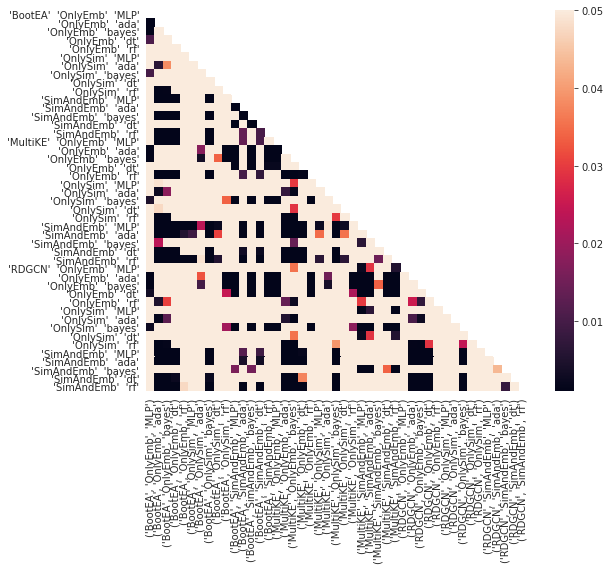

In [169]:
mask = np.zeros_like(nm_test)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 7))
    ax = sns.heatmap(nm_test,vmax=.05,square=True,mask=mask,xticklabels=True,yticklabels=True)
    new_y_labels = []
    levels1 = []
    levels2 = []
    for l in ax.get_yticklabels():
        trip = l.get_text().replace("(","").replace(")","").split(",")
        if trip[0] not in levels1:
            new_y_labels.append(" ".join(trip))
            levels1.append(trip[0])
        else:
            new_y_labels.append("".join(trip[1:]))

    ax.set_yticklabels(new_y_labels)

In [80]:
rich_df[rich_df["embed_model"]=="BootEA"].groupby(["model_name","vector_name","dataset"]).mean().loc[("MLP","OnlyEmb")]

,prec,rec,fm
dataset,,,
D_W_100K_V1,0.999770,0.760111,0.863591
D_W_100K_V2,0.999637,0.913063,0.954376
D_W_15K_V1,0.997989,0.629543,0.771876
D_W_15K_V2,0.996551,0.891257,0.940961
D_Y_100K_V1,0.999440,0.922483,0.959418
D_Y_100K_V2,0.999343,0.960226,0.979392
D_Y_15K_V1,0.999489,0.709238,0.829318
D_Y_15K_V2,0.998710,0.945829,0.971420
EN_DE_100K_V1,0.999463,0.824140,0.903364


# General Remarks

- For each dataset there are 5 folds
- on each fold a 7-2-1 split:
    - 70% testing
    - 20% training
    - 10% validation
- Results show the F-measure on the test data averaged over the 5 folds

# Analysis of Rich Graph Datasets

Our hypothesis is that Knowledge Graph Embeddings (KGEs) perform well on datasets that with many edges between vertices. We also have the hypothesis that using both: KGEs and attribute similarities will have a beneficial effect on classifier performance. We gave several classifiers the following different features:

-__SimAndEmb__: Attribute similarities/distances and embeddings

-__OnlySim__: Only Attribute similarities/distances

-__SimAndEmbNormalized__: Attribute similarities and embeddings

-__OnlySimNormalized__: Attribute similarities normalized between 0 and 1

-__OnlyEmb__: Only euclidean distance
    
We do this for each different embedding method

## Analysis of Feature Input for RDGCN
To check if using embeddings in conjunction with similarities provides an improvement overall we sum the test_f1 value over all folds

In [70]:
rich_expanded = get_expanded_df(rich_df,"embed_model","RDGCN",["model_name","vector_name","dataset"])
stylized = stylize(rich_expanded)
stylized

KeyError: 'MLP'

Mean row wise rank (the lower the better):

In [ ]:
rank_order = rich_expanded.apply(lambda x: x.rank(ascending=False), axis=1).mean().sort_values()
# sort columns by rank to make nemenyi table easier to understand
rich_expanded = rich_expanded.reindex(rank_order.index, axis=1)
rank_order

Using embeddings AND similarity seems to improve the results.
Let's test if the difference is significant!

The Friedman test is designed to check if there is a significant difference in the rank sums.
If this is the case a nemenyi test is applied pairwise to check which differences are significant.

In [ ]:
res = statistical_test(rich_expanded)
res

Values below 0.05 show a significant difference. So keeping the mean row wise ranks in mind:
SimAndEmb is significantly better than all other approaches.

# Analysis of Feature Input for MultiKE
To check if using embeddings in conjunction with similarities provides an improvement overall we sum the test_f1 value over all folds

In [62]:
rich_expanded = get_expanded_df(rich_df,"embed_model","MultiKE",["model_name","vector_name","dataset"])
stylized = stylize(rich_expanded)
stylized

,SimAndEmb,OnlyEmb,OnlySim
dataset,,,
D_W_100K_V1_MLP,0.86,0.84,0.64
D_W_100K_V1_ada boost,0.8,0.51,0.72
D_W_100K_V1_decision tree,0.8,0.65,0.71
D_W_100K_V1_gaussian naive bayes,0.62,0.5,0.31
D_W_100K_V1_random forest 500,0.83,0.87,0.72
D_W_100K_V2_MLP,0.94,0.91,0.71
D_W_100K_V2_ada boost,0.88,0.52,0.71
D_W_100K_V2_decision tree,0.86,0.75,0.74
D_W_100K_V2_gaussian naive bayes,0.67,0.51,0.42


Mean row wise rank (the lower the better):

In [ ]:
rank_order = rich_expanded.apply(lambda x: x.rank(ascending=False), axis=1).mean().sort_values()
# sort columns by rank to make nemenyi table easier to understand
rich_expanded = rich_expanded.reindex(rank_order.index, axis=1)
rank_order

In [ ]:
res = statistical_test(rich_expanded)
res

## Analysis of Feature Input for BootEA
To check if using embeddings in conjunction with similarities provides an improvement overall we sum the test_f1 value over all folds

In [ ]:
rich_expanded = get_expanded_df(rich_df,"embed_model","BootEA",["model_name","vector_name","dataset"])
stylized = stylize(rich_expanded)
stylized

Mean row wise rank (the lower the better):

In [ ]:
rank_order = rich_expanded.apply(lambda x: x.rank(ascending=False), axis=1).mean().sort_values()
# sort columns by rank to make nemenyi table easier to understand
rich_expanded = rich_expanded.reindex(rank_order.index, axis=1)
rank_order

In [ ]:
res = statistical_test(rich_expanded)
res

# Analysis of shallow Datasets

Our hypothesis here is that Knowledge Graph Embeddings (KGEs) don't significantly improve the results, because there is too little information in the embedding process

## Analysis of Feature Input for RDGCN
To check if using embeddings in conjunction with similarities provides an improvement overall we sum the test_f1 value over all folds

In [ ]:
shallow_expanded = get_expanded_df(shallow_df,"embed_model","RDGCN",["model_name","vector_name","dataset"])
stylized = stylize(shallow_expanded)
stylized

Mean row wise rank (the lower the better):

In [ ]:
rank_order = shallow_expanded.apply(lambda x: x.rank(ascending=False), axis=1).mean().sort_values()
# sort columns by rank to make nemenyi table easier to understand
shallow_expanded = shallow_expanded.reindex(rank_order.index, axis=1)
rank_order

In [ ]:
res = statistical_test(shallow_expanded)
res

# Analysis of Feature Input for MultiKE
To check if using embeddings in conjunction with similarities provides an improvement overall we sum the test_f1 value over all folds

In [ ]:
shallow_expanded = get_expanded_df(shallow_df,"embed_model","MultiKE",["model_name","vector_name","dataset"])
stylized = stylize(shallow_expanded)
stylized

Mean row wise rank (the lower the better):

In [ ]:
rank_order = shallow_expanded.apply(lambda x: x.rank(ascending=False), axis=1).mean().sort_values()
# sort columns by rank to make nemenyi table easier to understand
shallow_expanded = shallow_expanded.reindex(rank_order.index, axis=1)
rank_order

In [ ]:
res = statistical_test(shallow_expanded)
res

## Analysis of Feature Input for BootEA
To check if using embeddings in conjunction with similarities provides an improvement overall we sum the test_f1 value over all folds

In [ ]:
shallow_expanded = get_expanded_df(shallow_df,"embed_model","BootEA",["model_name","vector_name","dataset"])
stylized = stylize(shallow_expanded)
stylized

Mean row wise rank (the lower the better):

In [ ]:
rank_order = shallow_expanded.apply(lambda x: x.rank(ascending=False), axis=1).mean().sort_values()
# sort columns by rank to make nemenyi table easier to understand
shallow_expanded = shallow_expanded.reindex(rank_order.index, axis=1)
rank_order

In [ ]:
res = statistical_test(shallow_expanded)
res

## Analysis of Classifier Performance (on SimAndEmb)
Similarly we analyze the different performance of the classifiers. We are interested in the performance using both: similarities and embeddings

In [61]:
whole_df = get_expanded_df(df,"vector_name","SimAndEmb",["embed_model","model_name","dataset"])
stylized = stylize(whole_df)
stylized

,MLP,ada boost,decision tree,gaussian naive bayes,random forest 500
dataset,,,,,
D_W_100K_V1_BootEA,0.87,0.83,0.81,0.9,0.88
D_W_100K_V1_MultiKE,0.86,0.8,0.8,0.62,0.83
D_W_100K_V1_RDGCN,0.72,0.72,0.71,0.63,0.73
D_W_100K_V2_BootEA,0.96,0.81,0.82,0.98,0.95
D_W_100K_V2_MultiKE,0.94,0.88,0.86,0.67,0.92
D_W_100K_V2_RDGCN,0.74,0.74,0.73,0.68,0.77
D_W_15K_V1_BootEA,0.8,0.52,0.51,0.84,0.82
D_W_15K_V1_MultiKE,0.89,0.85,0.78,0.67,0.86
D_W_15K_V1_RDGCN,0.82,0.8,0.77,0.68,0.83


mean row wise rank

In [ ]:
rank_order = whole_df.apply(lambda x: x.rank(ascending=False), axis=1).mean().sort_values()
# sort columns by rank to make nemenyi table easier to understand
whole_df = whole_df.reindex(rank_order.index, axis=1)
rank_order

In [ ]:
res = statistical_test(whole_df)
res

In [ ]:
piv.round(3).style.background_gradient(axis=1)

In [ ]:
add_rank(piv.round(3))

In [ ]:
df[df["embed_model"]=="MultiKE"]["test_f1"].reset_index(drop=True) - df[df["embed_model"]=="BootEA"]["test_f1"].reset_index(drop=True)